# OLID (Offensive Language Identification Dataset)
Predicting the Type and Target of Offensive Posts in Social Media

## Import Libraries

In [349]:
import pandas as pd
import string
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords as st
import random

from warnings import filterwarnings
filterwarnings("ignore")

## Define Functions

In [205]:
def plot_conf_matrix(test_label,predicted_label):
    cm = confusion_matrix(test_label,predicted_label)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')  

In [ ]:
## For augumentation
import nlpaug.augmenter.word as naw

# Initialize augmenters
aug_synonym = naw.SynonymAug(aug_src='wordnet')
aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
aug_delete = naw.RandomWordAug(action="delete")
aug_swap = naw.RandomWordAug(action="swap")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


Original Tweet: I love natural language processing!
Synonym Replacement: ['Single love natural language processing!']
Random Insertion: ['i simply love natural language image processing!']
Random Deletion: ['Love natural processing!']
Random Swap: ['Love I natural processing language!']


In [206]:
# Sample tweet
tweet = "I love natural language processing!"

# Apply augmentations


aug_synonym_tweet = ' '.join(aug_synonym.augment(tweet.split()))
aug_insert_tweet = ' '.join(aug_insert.augment(tweet.split()))
aug_delete_tweet = ' '.join(aug_delete.augment(tweet.split()))
aug_swap_tweet = ' '.join(aug_swap.augment(tweet.split()))

# Display augmented tweets
print("Original Tweet:", tweet)
print("Synonym Replacement:", aug_synonym_tweet)
print("Random Insertion:", aug_insert_tweet)
print("Random Deletion:", aug_delete_tweet)
print("Random Swap:", aug_swap_tweet)

Original Tweet: I love natural language processing!
Synonym Replacement: Ace sexual love instinctive linguistic communication processing!
Random Insertion: could i puppy love el natural spanish language data processing!
Random Deletion: I love natural language !
Random Swap: I love natural language ! processing


## Data 

### Data Loading

In [207]:
training_data=pd.read_csv('./Datasets/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')
training_data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [421]:
train_tweets_temp = training_data[['tweet']] #Extract tweets
train_tweets_temp


,tweet
0,@USER She should ask a few native Americans wh...
1,@USER @USER Go home you’re drunk!!! @USER #MAG...
2,Amazon is investigating Chinese employees who ...
3,"@USER Someone should'veTaken"" this piece of sh..."
4,@USER @USER Obama wanted liberals &amp; illega...
...,...
13235,@USER Sometimes I get strong vibes from people...
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...
13237,@USER And why report this garbage. We don't g...
13238,@USER Pussy


In [209]:
train_task_a_labels= training_data[['subtask_a']] #Extract subtsak_a labels
train_task_b_labels= training_data[['subtask_b']] #Extract subtsak_b labels
train_task_c_labels= training_data[['subtask_c']] #Extract subtsak_c labels

train_task_a_labels.columns.values[0] = 'class_a' #Rename class attribute
train_task_b_labels.columns.values[0] = 'class_b' #Rename class attribute
train_task_c_labels.columns.values[0] = 'class_c' #Rename class attribute

### Data preprocessing

In [422]:
train_tweets_temp
tweet_colm=train_tweets_temp.iloc[:,0]
data=tweet_colm[3]
data
print(tweet_colm)

0        @USER She should ask a few native Americans wh...
1        @USER @USER Go home you’re drunk!!! @USER #MAG...
2        Amazon is investigating Chinese employees who ...
3        @USER Someone should'veTaken" this piece of sh...
4        @USER @USER Obama wanted liberals &amp; illega...
                               ...                        
13235    @USER Sometimes I get strong vibes from people...
13236    Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...
13237    @USER And why report this garbage.  We don't g...
13238                                          @USER Pussy
13239    #Spanishrevenge vs. #justice #HumanRights and ...
Name: tweet, Length: 13240, dtype: object


#Function to clean tweets in a data frame's tweet column
def clean_tweets(df):
    stopwords = set(st.words("english"))
    #Stopwords
    tweet_colm = df.iloc[:,0]
    data = tweet_colm[3]
    x = [word for word in data.split() if word.lower() not in stopwords]
    data_1 = " ".join(x)
    data_1 = [data_1]
    tweet_colm[3] = data_1[0]
    df.loc[:, 'tweet'] = tweet_colm
    
    punctuations = string.punctuation
    
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '') #Remove mentions (@USER)
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '') #Remove URLs
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and') #Replace ampersand (&) with and
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','') #Remove &lt
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','') #Remove &gt
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.lower() #Lowercase

    #Remove punctuations
    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')

    df.loc[:, 'tweet'] = df.astype(str).apply(
        lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')
    )
    #Remove emojis
    df.loc[:, 'tweet'] = df.tweet.str.strip() #Trim leading and trailing whitespaces

In [411]:
def remove_stopwords(df):
    stopwords = set(st.words("english"))
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))
    df['tweet'] = df['tweet'].str.strip()  # Trim leading and trailing whitespaces
    return df

In [424]:
def clean_tweets(df):
    stopwords = set(st.words("english"))
    punctuations = string.punctuation
    
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '') #Remove mentions (@USER)
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '') #Remove URLs
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and') #Replace ampersand (&) with and
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','') #Remove &lt
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','') #Remove &gt
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.lower() #Lowercase

    #Remove punctuations
    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')

    df.loc[:, 'tweet'] = df.astype(str).apply(
        lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')
    )
    #Remove emojis
    df.loc[:, 'tweet'] = df.tweet.str.strip() #Trim leading and trailing whitespaces
    df=remove_stopwords(df)
    return df
    

In [425]:
df=pd.DataFrame({"tweet": "I love this movie"},index=[0]) 
df=clean_tweets(df)
df

,tweet
0,love movie


In [426]:
train_tweets=clean_tweets(train_tweets_temp)
train_tweets

,tweet
0,ask native americans take
1,go home youre drunk maga trump
2,amazon investigating chinese employees selling...
3,someone shouldvetaken piece shit volcano
4,obama wanted liberals illegals move red states
...,...
13235,sometimes get strong vibes people mans vibe te...
13236,benidorm creamfields maga shabby summer
13237,report garbage dont give crap
13238,pussy


#### Preparing the training data

##### Task A

In [427]:
train_task_a_data = train_tweets.join(train_task_a_labels)
train_task_a_data


,tweet,class_a
0,ask native americans take,OFF
1,go home youre drunk maga trump,OFF
2,amazon investigating chinese employees selling...,NOT
3,someone shouldvetaken piece shit volcano,OFF
4,obama wanted liberals illegals move red states,NOT
...,...,...
13235,sometimes get strong vibes people mans vibe te...,OFF
13236,benidorm creamfields maga shabby summer,NOT
13237,report garbage dont give crap,OFF
13238,pussy,OFF


##### Task B

In [428]:
train_task_b_data = train_tweets.join(train_task_b_labels)
train_task_b_data = train_task_b_data.dropna() #Drop records with missing values
train_task_b_data

,tweet,class_b
0,ask native americans take,UNT
1,go home youre drunk maga trump,TIN
3,someone shouldvetaken piece shit volcano,UNT
5,liberals kookoo,TIN
6,oh noes tough shit,UNT
...,...,...
13223,advocating conduct within bounds human rights ...,TIN
13227,liars like antifa twins vigorously defend,TIN
13235,sometimes get strong vibes people mans vibe te...,TIN
13237,report garbage dont give crap,TIN


Let us attempt to perform augumentation using nlpaug

In [429]:
# Create a new DataFrame for augmented tweets
augmented_train_b = pd.DataFrame(columns=['tweet', 'class_b'])

# Iterate through the original DataFrame
for index, row in train_task_b_data.iterrows():
    tweet = row['tweet']
    label = row['class_b']

    # Only augment tweets with the label 'UNT'
    if label == 'UNT':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        # Add augmented tweets to the new DataFrame
        augmented_train_b = augmented_train_b.append({'tweet': augmented_synonym, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_insert, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_delete, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_swap, 'class_b': label}, ignore_index=True)

# Concatenate the original DataFrame with the augmented DataFrame
train_taskb_augmented_data = pd.concat([train_task_b_data, augmented_train_b], ignore_index=True)

# Display the augmented dataset
print(train_taskb_augmented_data)


KeyboardInterrupt: 

##### Task C

In [216]:
train_task_c_data = train_tweets.join(train_task_c_labels)
train_task_c_data = train_task_c_data.dropna() #Drop records with missing values
train_task_c_data


,tweet,class_c
1,go home youre drunk maga trump,IND
5,liberals are all kookoo,OTH
7,was literally just talking about this lol all ...,GRP
9,canada doesnt need another cuck we already hav...,IND
12,you are a lying corrupt traitor nobody wants t...,IND
...,...,...
13212,everything else was ten years ago you are a ...,IND
13223,is advocating for conduct within bounds of hum...,GRP
13227,liars like the antifa twins you vigorously defend,GRP
13235,sometimes i get strong vibes from people and t...,IND


In [194]:
# Create a new DataFrame for augmented tweets
augmented_train_c = pd.DataFrame(columns=['tweet', 'class_c'])

# Iterate through the original DataFrame
for index, row in train_task_c_data.iterrows():
    tweet = row['tweet']
    label = row['class_c']
    # Only augment tweets with the label 'UNT'
    if label == 'GRP':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))
        aug=[augmented_synonym, augmented_insert, augmented_delete, augmented_swap]
        # Add augmented tweets to the new DataFrame
        random_number = random.randint(0, 3)
        augmented_train_c = augmented_train_c.append({'tweet': aug[random_number], 'class_c': label}, ignore_index=True)
        # Print the number of tweets added to the DataFrame
    elif label== 'OTH':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        augmented_train_c = augmented_train_c.append({'tweet': augmented_synonym, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_insert, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_delete, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_swap, 'class_c': label}, ignore_index=True)

        

# Concatenate the original DataFrame with the augmented DataFrame
train_taskc_augmented_data = pd.concat([train_task_c_data, augmented_train_c], ignore_index=True)

# Display the augmented dataset
print(train_taskc_augmented_data)


                                                  tweet class_c
0                       go home youre drunk  maga trump     IND
1                               liberals are all kookoo     OTH
2     was literally just talking about this lol all ...     GRP
3     canada doesnt need another cuck we already hav...     IND
4     you are a lying corrupt traitor nobody wants t...     IND
...                                                 ...     ...
6525  liars like the antifa twins you vigorously defend     GRP
6526  and wherefore write up this refuse we dont kic...     OTH
6527  4 and his why special report do this sea garba...     OTH
6528    and why report this garbage we dont give a crap     OTH
6529    and why report this garbage we dont give a crap     OTH

[6530 rows x 2 columns]


##### Final Prep

In [430]:
train_task_a_data.update(train_task_a_data[['tweet']].applymap('\'{}\''.format))
train_task_b_data.update(train_task_b_data[['tweet']].applymap('\'{}\''.format))
train_taskb_augmented_data.update(train_taskb_augmented_data[['tweet']].applymap('\'{}\''.format))
train_task_c_data.update(train_task_c_data[['tweet']].applymap('\'{}\''.format))
train_taskc_augmented_data.update(train_taskc_augmented_data[['tweet']].applymap('\'{}\''.format))

#### Preparing the test sets

##### Task A

In [436]:
#Read tweets from test sets
test_tweet_a=pd.read_csv('./Datasets/testset-levela.tsv', delimiter='\t', encoding='utf-8')
test_label_a=pd.read_csv('./Datasets/labels-levela.csv', encoding='utf-8', index_col=False, names=['id', 'class_a'])
print(test_label_a)


        id class_a
0    15923     OFF
1    27014     NOT
2    30530     NOT
3    13876     NOT
4    60133     OFF
..     ...     ...
855  73439     OFF
856  25657     NOT
857  67018     OFF
858  50665     NOT
859  24583     NOT

[860 rows x 2 columns]


In [437]:
test_tweet_a = test_tweet_a.merge(test_label_a, on='id')
print(test_tweet_a)


        id                                              tweet class_a
0    15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...     OFF
1    27014  #ConstitutionDay is revered by Conservatives, ...     NOT
2    30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...     NOT
3    13876  #Watching #Boomer getting the news that she is...     NOT
4    60133  #NoPasaran: Unity demo to oppose the far-right...     OFF
..     ...                                                ...     ...
855  73439  #DespicableDems lie again about rifles. Dem Di...     OFF
856  25657  #MeetTheSpeakers 🙌 @USER will present in our e...     NOT
857  67018  3 people just unfollowed me for talking about ...     OFF
858  50665  #WednesdayWisdom Antifa calls the right fascis...     NOT
859  24583      #Kavanaugh typical #liberals , #Democrats URL     NOT

[860 rows x 3 columns]


In [438]:
test_tweet_a = test_tweet_a.drop(columns='id')
print(test_tweet_a)


                                                 tweet class_a
0    #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...     OFF
1    #ConstitutionDay is revered by Conservatives, ...     NOT
2    #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...     NOT
3    #Watching #Boomer getting the news that she is...     NOT
4    #NoPasaran: Unity demo to oppose the far-right...     OFF
..                                                 ...     ...
855  #DespicableDems lie again about rifles. Dem Di...     OFF
856  #MeetTheSpeakers 🙌 @USER will present in our e...     NOT
857  3 people just unfollowed me for talking about ...     OFF
858  #WednesdayWisdom Antifa calls the right fascis...     NOT
859      #Kavanaugh typical #liberals , #Democrats URL     NOT

[860 rows x 2 columns]


In [439]:
clean_tweets(test_tweet_a)
test_tweet_a

,tweet,class_a
0,whoisq wherestheserver dumpnike declasfisa dem...,OFF
1,constitutionday revered conservatives hated pr...,NOT
2,foxnews nra maga potus trump ndamendment rnc u...,NOT
3,watching boomer getting news still parole alwa...,NOT
4,nopasaran unity demo oppose farright london an...,OFF
...,...,...
855,despicabledems lie rifles dem distorted law pu...,OFF
856,meetthespeakers present event oiw finpact glob...,NOT
857,people unfollowed talking merlin sorry yall im...,OFF
858,wednesdaywisdom antifa calls right fascist rea...,NOT


In [440]:
test_tweet_a.update(test_tweet_a[['tweet']].applymap('\'{}\''.format))
test_tweet_a

,tweet,class_a
0,'whoisq wherestheserver dumpnike declasfisa de...,OFF
1,'constitutionday revered conservatives hated p...,NOT
2,'foxnews nra maga potus trump ndamendment rnc ...,NOT
3,'watching boomer getting news still parole alw...,NOT
4,'nopasaran unity demo oppose farright london a...,OFF
...,...,...
855,'despicabledems lie rifles dem distorted law p...,OFF
856,'meetthespeakers present event oiw finpact glo...,NOT
857,'people unfollowed talking merlin sorry yall i...,OFF
858,'wednesdaywisdom antifa calls right fascist re...,NOT


##### Task B

In [219]:
test_tweet_b=pd.read_csv('./Datasets/testset-levelb.tsv', delimiter='\t', encoding='utf-8')
test_label_b=pd.read_csv('./Datasets/labels-levelb.csv', encoding='utf-8', index_col=False, names=['id', 'class_b'])
test_tweet_b = test_tweet_b.merge(test_label_b, on='id')
test_tweet_b = test_tweet_b.drop(columns='id')
clean_tweets(test_tweet_b)
test_tweet_b.update(test_tweet_b[['tweet']].applymap('\'{}\''.format))
test_tweet_b

,tweet,class_b
0,'whoisq wherestheserver dumpnike declasfisa de...,TIN
1,'nopasaran unity demo to oppose the farright i...,TIN
2,'what the fuck did he do this time',TIN
3,'get feeling kissing behind humiliate later',TIN
4,'nigga ware da hits at',UNT
...,...,...
235,'antifa are mentally unstable cowards pretendi...,TIN
236,'and browning looked like dog shit against the...,TIN
237,'all two of them taste like ass',TIN
238,'despicabledems lie again about rifles dem dis...,TIN


In [165]:
# Create a new DataFrame for augmented tweets
augmented_test_b = pd.DataFrame(columns=['tweet', 'class_b'])

# Iterate through the original DataFrame
for index, row in test_tweet_b.iterrows():
    tweet = row['tweet']
    label = row['class_b']

    # Only augment tweets with the label 'UNT'
    if label == 'UNT':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        # Add augmented tweets to the new DataFrame
        augmented_test_b = augmented_test_b.append({'tweet': augmented_synonym, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_insert, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_delete, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_swap, 'class_b': label}, ignore_index=True)

# Concatenate the original DataFrame with the augmented DataFrame
test_taskb_augmented_data = pd.concat([test_tweet_b, augmented_test_b], ignore_index=True)

# Display the augmented dataset
print(test_taskb_augmented_data)


                                                 tweet class_b
0    'whoisq wherestheserver dumpnike declasfisa de...     TIN
1    'nopasaran unity demo to oppose the farright i...     TIN
2                  'what the fuck did he do this time'     TIN
3        'get feeling kissing  behind humiliate later'     TIN
4                              'nigga ware da hits at'     UNT
..                                                 ...     ...
343  Howtogetpeopleoutofyourhome ' tell them that y...     UNT
344  ' citizenry only unfollowed maine for peach as...     UNT
345  ' about people ... just still unfollowed for m...     UNT
346  ' just unfollowed me for talking about merlin ...     UNT
347  People ' just unfollowed me for talking about ...     UNT

[348 rows x 2 columns]


##### Task C

In [220]:
test_tweet_c=pd.read_csv('./Datasets/testset-levelc.tsv', delimiter='\t', encoding='utf-8')
test_label_c=pd.read_csv('./Datasets/labels-levelc.csv', encoding='utf-8', index_col=False, names=['id', 'class_c'])
test_tweet_c = test_tweet_c.merge(test_label_c, on='id')
test_tweet_c = test_tweet_c.drop(columns='id')
clean_tweets(test_tweet_c)
test_tweet_c.update(test_tweet_c[['tweet']].applymap('\'{}\''.format))
test_tweet_c

,tweet,class_c
0,'whoisq wherestheserver dumpnike declasfisa de...,OTH
1,'nopasaran unity demo to oppose the farright i...,GRP
2,'what the fuck did he do this time',IND
3,'get feeling kissing behind humiliate later',OTH
4,'stopkavanaugh he is liar like the rest of the...,IND
...,...,...
208,'stopetchecopar fuck you all que florezcan mi...,IND
209,'antifa are mentally unstable cowards pretendi...,GRP
210,'and browning looked like dog shit against the...,IND
211,'all two of them taste like ass',GRP


In [221]:
# Create a new DataFrame for augmented tweets
augmented_test_c = pd.DataFrame(columns=['tweet', 'class_c'])

# Iterate through the original DataFrame
for index, row in test_tweet_c.iterrows():
    tweet = row['tweet']
    label = row['class_c']
    # Only augment tweets with the label 'UNT'
    if label == 'OTH':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))
        aug=[augmented_synonym, augmented_insert, augmented_delete, augmented_swap]
        # Add augmented tweets to the new DataFrame
        random_number = random.randint(0, 3)
        augmented_test_c = augmented_test_c.append({'tweet': aug[random_number], 'class_c': label}, ignore_index=True)
        # Print the number of tweets added to the DataFrame


# Concatenate the original DataFrame with the augmented DataFrame
test_taskc_augmented_data = pd.concat([test_tweet_c, augmented_test_c], ignore_index=True)

# Display the augmented dataset
print(test_taskc_augmented_data)


                                                 tweet class_c
0    'whoisq wherestheserver dumpnike declasfisa de...     OTH
1    'nopasaran unity demo to oppose the farright i...     GRP
2                  'what the fuck did he do this time'     IND
3        'get feeling kissing  behind humiliate later'     OTH
4    'stopkavanaugh he is liar like the rest of the...     IND
..                                                 ...     ...
243  ' as christineblaseyford there was food grindi...     OTH
244  ' justiceforsoniasfather mr. usman buzdar bach...     OTH
245  ' these sick ass ppl from school gave me somet...     OTH
246  ' [UNK] conservatives variants are and dumbert...     OTH
247  ' about brexit al deal he has ever been paradi...     OTH

[248 rows x 2 columns]


### Data Visualization

#### Task A

train data class_a
NOT    8840
OFF    4400
Name: class_a, dtype: int64


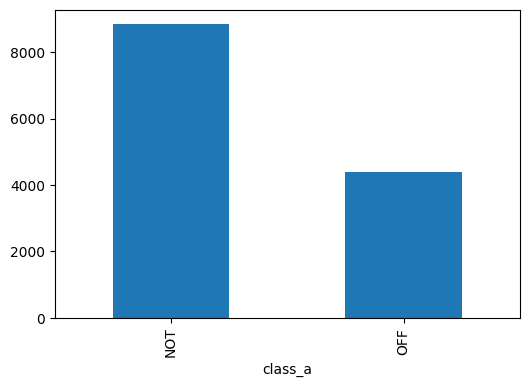

In [115]:
# Quick look at the topic numbers on the total dataset
fig = plt.figure(figsize=(6,4))
print("train data",train_task_a_data.groupby('class_a').class_a.count())
train_task_a_data.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

test data class_a
NOT    620
OFF    240
Name: class_a, dtype: int64


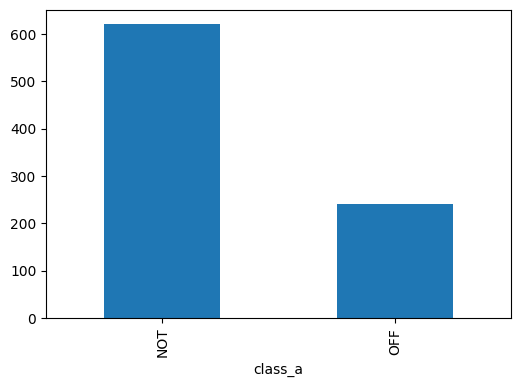

In [116]:
# Quick look at the topic numbers on the total dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_a.groupby('class_a').class_a.count())
test_tweet_a.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

#### Task B

train data class_b
TIN    3876
UNT     524
Name: class_b, dtype: int64


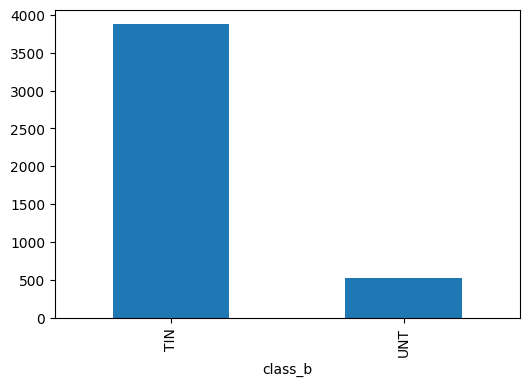

In [117]:
# Quick look at the topic numbers on the total dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
print("train data",train_task_b_data.groupby('class_b').class_b.count())
train_task_b_data.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

test data class_b
TIN    213
UNT     27
Name: class_b, dtype: int64


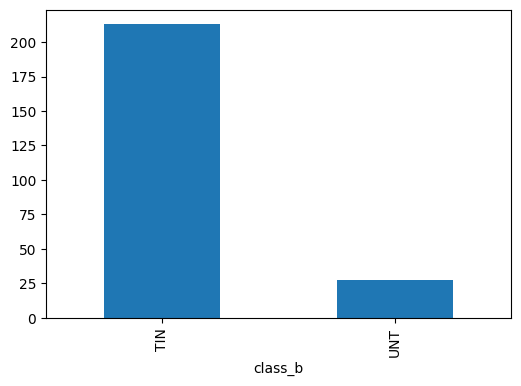

In [118]:
# Quick look at the topic numbers on the total dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_b.groupby('class_b').class_b.count())
test_tweet_b.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

If we use the above data as is and train a model on it, we get a high accuracy of 89%. However, we have a recall of 1. This implies that the model has classified all the reviews as positive or TIN, which is not the case. This happens when there is a high skew in the dataset, which exists in our dataset (3876, 524). Hence, we must use techniques such as over/under sampling or data augumentation to reduce the skewness in the dataset.

##### Augumented Data

In [157]:
train_taskb_augmented_data

,tweet,class_b
0,she should ask a few native americans what the...,UNT
1,go home youre drunk maga trump,TIN
2,someone shouldvetaken piece shit volcano,UNT
3,liberals are all kookoo,TIN
4,oh noes tough shit,UNT
...,...,...
6491,my head is a fuckin egg,UNT
6492,puss,UNT
6493,my pussy,UNT
6494,pussy,UNT


train data class_b
TIN    3876
UNT    2620
Name: class_b, dtype: int64


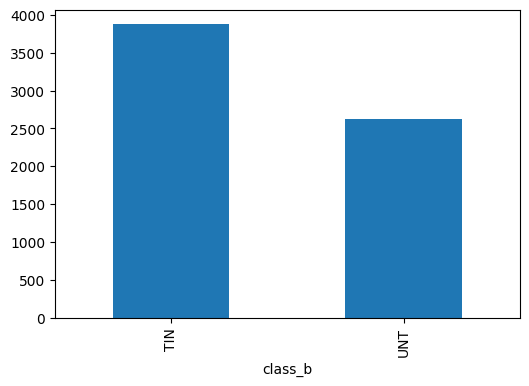

In [158]:
# Quick look at the topic numbers on the total dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
print("train data",train_taskb_augmented_data.groupby('class_b').class_b.count())
train_taskb_augmented_data.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

#### Task C

train data class_c
GRP    1074
IND    2407
OTH     395
Name: class_c, dtype: int64


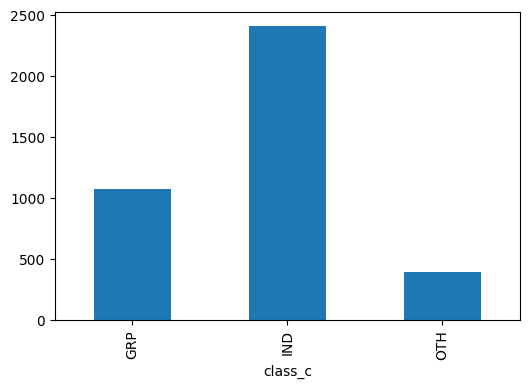

In [196]:
# Quick look at the topic numbers on the total dataset

fig = plt.figure(figsize=(6,4))
print("train data",train_task_c_data.groupby('class_c').class_c.count())
train_task_c_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

test data class_c
GRP     78
IND    100
OTH     35
Name: class_c, dtype: int64


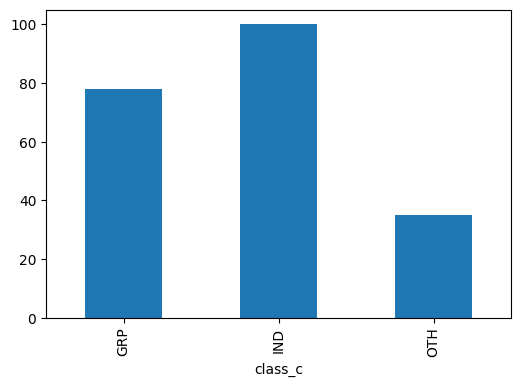

In [121]:
# Quick look at the topic numbers on the total dataset
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_c.groupby('class_c').class_c.count())
test_tweet_c.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

Let us visualize the augumented data

train data class_c
GRP    2148
IND    2407
OTH    1975
Name: class_c, dtype: int64


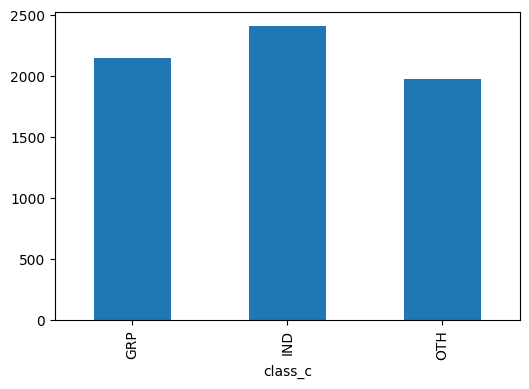

In [222]:
# Quick look at the topic numbers on the total dataset

fig = plt.figure(figsize=(6,4))
print("train data",train_taskc_augmented_data.groupby('class_c').class_c.count())
train_taskc_augmented_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

test data class_c
GRP     78
IND    100
OTH     70
Name: class_c, dtype: int64


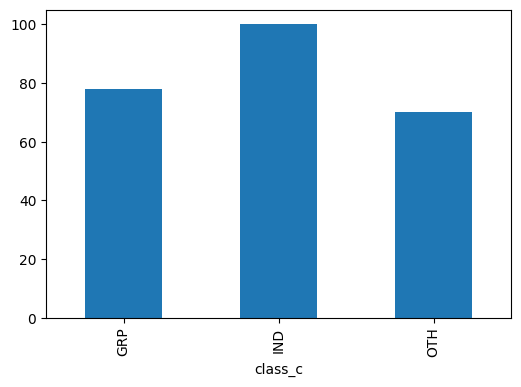

In [223]:
# Quick look at the topic numbers on the total dataset
fig = plt.figure(figsize=(6,4))
print("test data",test_taskc_augmented_data.groupby('class_c').class_c.count())
test_taskc_augmented_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

## Models

### 1st Model - MultinomialNB Naive Bayes

#### Task A

In [441]:
# Model
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_task_a_data["class_a_code"] = encoder.fit_transform(train_task_a_data["class_a"])
test_tweet_a["class_a_code"] = encoder.fit_transform(test_tweet_a["class_a"])

In [442]:
#Create tuple pair for class and class code
train_task_a_data['class-tuple'] = train_task_a_data[['class_a', 'class_a_code']].apply(tuple, axis=1)
class_a = train_task_a_data['class-tuple'].unique()
class_a

array([('OFF', 1), ('NOT', 0)], dtype=object)

In [443]:
# Split the Dataset as train and test set

X_train = train_task_a_data['tweet']
y_train = train_task_a_data['class_a_code']

X_test = test_tweet_a['tweet']
y_test = test_tweet_a['class_a_code']


print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (13240,) and shape of y_train is (13240,)
Shape of X_test is (860,) and shape of y_test is (860,)


In [444]:
# MultinomialNB Model
model= MultinomialNB()
pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, 
                                                        norm='l2', encoding='latin-1', 
                                                        ngram_range=(1, 2), stop_words='english')),
                         ('classifier', model)])

pipeline_Mnv.fit(X_train, y_train)
y_pred = pipeline_Mnv.predict(X_test)
accuracy_Mnv = accuracy_score(y_test, y_pred)
print("model accuracy:",accuracy_Mnv)
acc_taska_mb=accuracy_Mnv
print("\n")
print(metrics.classification_report(y_test, y_pred))

model accuracy: 0.7976744186046512


              precision    recall  f1-score   support

           0       0.79      0.97      0.87       620
           1       0.82      0.35      0.49       240

    accuracy                           0.80       860
   macro avg       0.81      0.66      0.68       860
weighted avg       0.80      0.80      0.77       860



In [445]:
import pickle
# Save the pipeline_Mnv to a file
with open('taskamnb.pkl', 'wb') as file:
    pickle.dump(pipeline_Mnv, file)

In [446]:
tweet=" You .. suck so hard"

In [452]:
df=pd.DataFrame({"tweet":"You suck so hard"},index=[0])
df.update(df[['tweet']].applymap('\'{}\''.format))
df


,tweet
0,'You suck so hard'


In [454]:
df=clean_tweets(df)
df

,tweet
0,suck hard


In [455]:

test=df['tweet']

In [456]:
pipeline_Mnv.predict(test)

array([1])

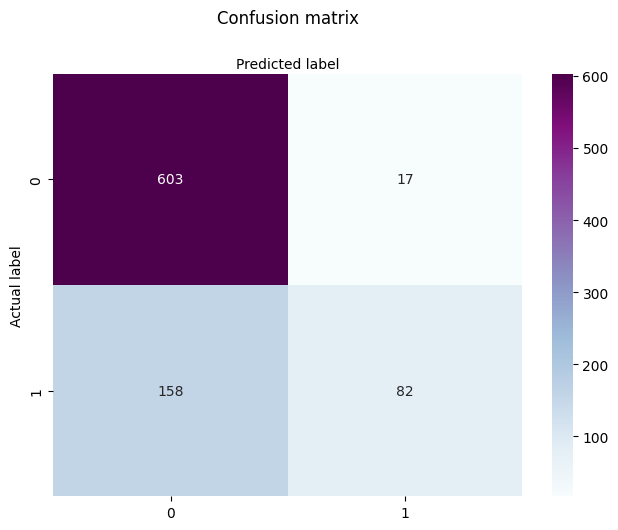

In [274]:
plot_conf_matrix(y_test,y_pred)

#### Task B

In [278]:
# Model
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_task_b_data["class_b_code"] = encoder.fit_transform(train_task_b_data["class_b"])
test_tweet_b["class_b_code"] = encoder.fit_transform(test_tweet_b["class_b"])

In [279]:
#Create tuple pair for class and class code
train_task_b_data['class-tuple'] = train_task_b_data[['class_b', 'class_b_code']].apply(tuple, axis=1)
class_b = train_task_b_data['class-tuple'].unique()
class_b

array([('UNT', 1), ('TIN', 0)], dtype=object)

In [280]:
# Split the Dataset as train and test set

X_train = train_task_b_data['tweet']
y_train = train_task_b_data['class_b_code']

X_test = test_tweet_b['tweet']
y_test = test_tweet_b['class_b_code']


print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (4400,) and shape of y_train is (4400,)
Shape of X_test is (240,) and shape of y_test is (240,)


In [281]:
# MultinomialNB Model
model= MultinomialNB()
pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, 
                                                        norm='l2', encoding='latin-1', 
                                                        ngram_range=(1, 2), stop_words='english')),
                         ('classifier', model)])

pipeline_Mnv.fit(X_train, y_train)
y_pred = pipeline_Mnv.predict(X_test)
accuracy_Mnv = accuracy_score(y_test, y_pred)
print("model accuracy:",accuracy_Mnv)
print("\n")
print(metrics.classification_report(y_test, y_pred))

model accuracy: 0.8875


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       213
           1       0.00      0.00      0.00        27

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240



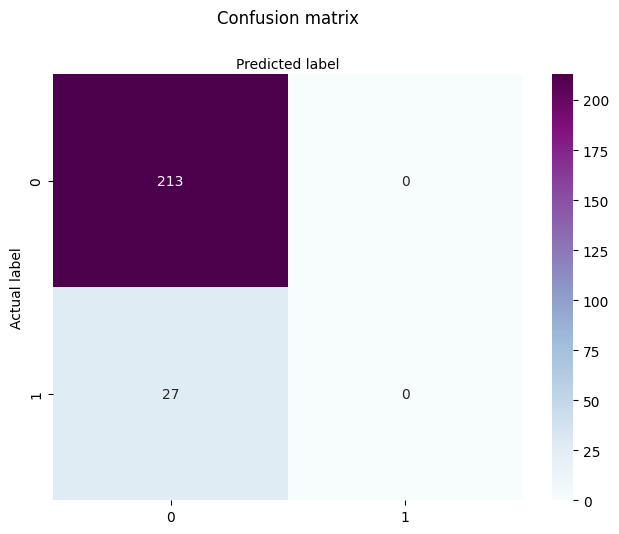

In [177]:
plot_conf_matrix(y_test,y_pred)

Let us try the same with augumented data

In [282]:
# Model
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_taskb_augmented_data["class_b_code"] = encoder.fit_transform(train_taskb_augmented_data["class_b"])
test_taskb_augmented_data["class_b_code"] = encoder.fit_transform(test_taskb_augmented_data["class_b"])

In [283]:
#Create tuple pair for class and class code
train_taskb_augmented_data['class-tuple'] = train_taskb_augmented_data[['class_b', 'class_b_code']].apply(tuple, axis=1)
class_b = train_taskb_augmented_data['class-tuple'].unique()
class_b

array([('UNT', 1), ('TIN', 0)], dtype=object)

In [284]:
# Split the Dataset as train and test set

X_train = train_taskb_augmented_data['tweet']
y_train = train_taskb_augmented_data['class_b_code']

X_test = test_taskb_augmented_data['tweet']
y_test = test_taskb_augmented_data['class_b_code']


print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (6496,) and shape of y_train is (6496,)
Shape of X_test is (348,) and shape of y_test is (348,)


In [285]:
# MultinomialNB Model
model= MultinomialNB()
pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, 
                                                        norm='l2', encoding='latin-1', 
                                                        ngram_range=(1, 2), stop_words='english')),
                         ('classifier', model)])

pipeline_Mnv.fit(X_train, y_train)
y_pred = pipeline_Mnv.predict(X_test)
accuracy_Mnv = accuracy_score(y_test, y_pred)
acc_taskb_mb=accuracy_Mnv
print("model accuracy:",accuracy_Mnv)
print("\n")
print(metrics.classification_report(y_test, y_pred))

model accuracy: 0.6867816091954023


              precision    recall  f1-score   support

           0       0.69      0.90      0.78       213
           1       0.69      0.35      0.46       135

    accuracy                           0.69       348
   macro avg       0.69      0.62      0.62       348
weighted avg       0.69      0.69      0.66       348



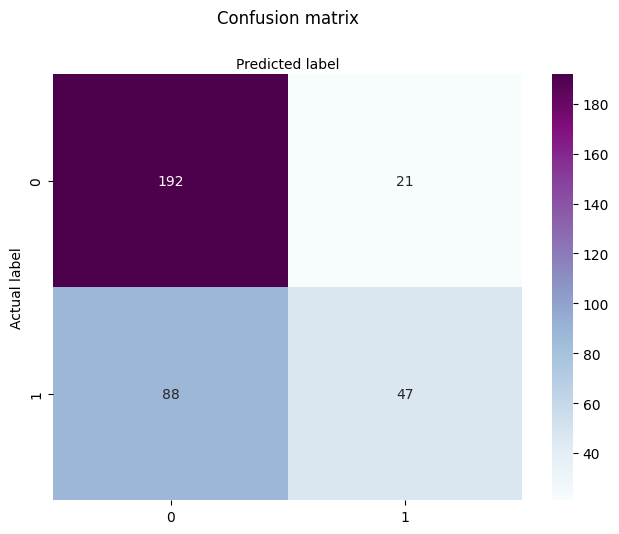

In [286]:
plot_conf_matrix(y_test,y_pred)

Hence, we can see that our model classifies slightly better with the augumented data

#### Task C

In [287]:
# Model
#creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_task_c_data["class_c_code"] = encoder.fit_transform(train_task_c_data["class_c"])
test_tweet_c["class_c_code"] = encoder.fit_transform(test_tweet_c["class_c"])

In [288]:
#Create tuple pair for class and class code
train_task_c_data['class-tuple'] = train_task_c_data[['class_c', 'class_c_code']].apply(tuple, axis=1)
class_c = train_task_c_data['class-tuple'].unique()
class_c

array([('IND', 1), ('OTH', 2), ('GRP', 0)], dtype=object)

In [289]:
# Split the Dataset as train and test set

X_train = train_task_c_data['tweet']
y_train = train_task_c_data['class_c_code']

X_test = test_tweet_c['tweet']
y_test = test_tweet_c['class_c_code']


print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (213,) and shape of y_test is (213,)


In [290]:
# MultinomialNB Model
model= MultinomialNB()
pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, 
                                                        norm='l2', encoding='latin-1', 
                                                        ngram_range=(1, 2), stop_words='english')),
                         ('classifier', model)])

pipeline_Mnv.fit(X_train, y_train)
y_pred = pipeline_Mnv.predict(X_test)
accuracy_Mnv = accuracy_score(y_test, y_pred)
acc_taskc_mb=accuracy_Mnv
print("model accuracy:",accuracy_Mnv)
print("\n")
print(metrics.classification_report(y_test, y_pred))

model accuracy: 0.568075117370892


              precision    recall  f1-score   support

           0       0.70      0.36      0.47        78
           1       0.54      0.93      0.68       100
           2       0.00      0.00      0.00        35

    accuracy                           0.57       213
   macro avg       0.41      0.43      0.39       213
weighted avg       0.51      0.57      0.49       213



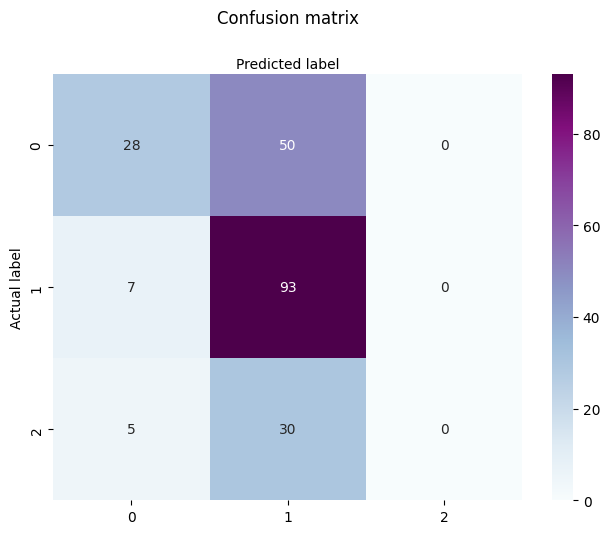

In [188]:
plot_conf_matrix(y_test,y_pred)

Augumented Data

In [291]:
# Model
# creating labelEncoder
encoder = LabelEncoder()
# Converting string labels into numbers.
train_taskc_augmented_data["class_c_code"] = encoder.fit_transform(train_taskc_augmented_data["class_c"])
test_taskc_augmented_data["class_c_code"] = encoder.fit_transform(test_taskc_augmented_data["class_c"])

In [292]:
#Create tuple pair for class and class code
train_taskc_augmented_data['class-tuple'] = train_taskc_augmented_data[['class_c', 'class_c_code']].apply(tuple, axis=1)
class_c = train_taskc_augmented_data['class-tuple'].unique()
class_c

array([('IND', 1), ('OTH', 2), ('GRP', 0)], dtype=object)

In [293]:
# Split the Dataset as train and test set

X_train = train_taskc_augmented_data['tweet']
y_train = train_taskc_augmented_data['class_c_code']

X_test = test_taskc_augmented_data['tweet']
y_test = test_taskc_augmented_data['class_c_code']


print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (6530,) and shape of y_train is (6530,)
Shape of X_test is (248,) and shape of y_test is (248,)


In [295]:
# MultinomialNB Model
model= MultinomialNB()
pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, 
                                                        norm='l2', encoding='latin-1', 
                                                        ngram_range=(1, 2), stop_words='english')),
                         ('classifier', model)])

pipeline_Mnv.fit(X_train, y_train)
y_pred = pipeline_Mnv.predict(X_test)
accuracy_Mnv = accuracy_score(y_test, y_pred)
acc_taskc_mb=accuracy_Mnv
print("model accuracy:",accuracy_Mnv)
print("\n")
print(metrics.classification_report(y_test, y_pred))

model accuracy: 0.5846774193548387


              precision    recall  f1-score   support

           0       0.52      0.59      0.55        78
           1       0.62      0.82      0.70       100
           2       0.63      0.24      0.35        70

    accuracy                           0.58       248
   macro avg       0.59      0.55      0.54       248
weighted avg       0.59      0.58      0.56       248



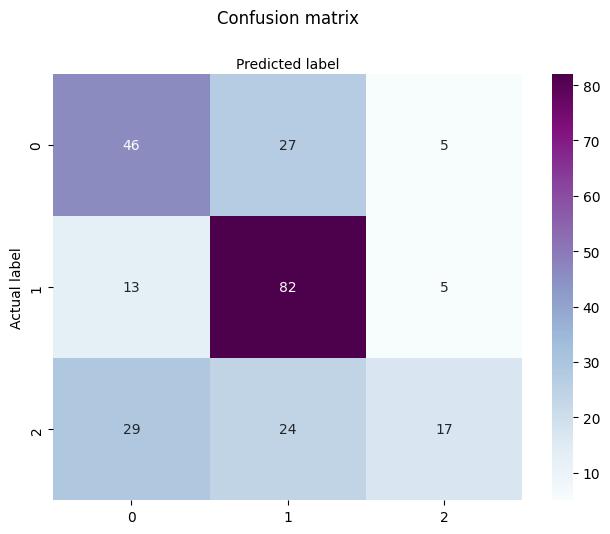

In [296]:
plot_conf_matrix(y_test,y_pred)

### 2nd Model - LSTM Text Classification

#### Task A

In [297]:
train_task_a_data

,tweet,class_a,class_a_code,class-tuple
0,'she should ask a few native americans what th...,OFF,1,"(OFF, 1)"
1,'go home youre drunk maga trump',OFF,1,"(OFF, 1)"
2,'amazon is investigating chinese employees who...,NOT,0,"(NOT, 0)"
3,'someone shouldvetaken piece shit volcano',OFF,1,"(OFF, 1)"
4,'obama wanted liberals and illegals to move in...,NOT,0,"(NOT, 0)"
...,...,...,...,...
13235,'sometimes i get strong vibes from people and ...,OFF,1,"(OFF, 1)"
13236,'benidorm creamfields maga not too shab...,NOT,0,"(NOT, 0)"
13237,'and why report this garbage we dont give a c...,OFF,1,"(OFF, 1)"
13238,'pussy',OFF,1,"(OFF, 1)"


In [298]:
train_task_a_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         13240 non-null  object
 1   class_a       13240 non-null  object
 2   class_a_code  13240 non-null  int32 
 3   class-tuple   13240 non-null  object
dtypes: int32(1), object(3)
memory usage: 362.2+ KB


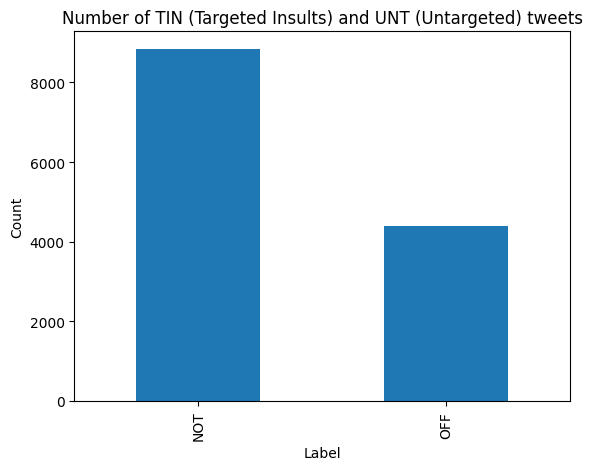

In [299]:
# Assuming 'class_a' is a categorical variable
class_counts = train_task_a_data['class_a'].value_counts()

class_counts.plot.bar()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of TIN (Targeted Insults) and UNT (Untargeted) tweets')
plt.show()


In [300]:
X_train = train_task_a_data.tweet
Y_train = train_task_a_data.class_a

X_test = test_tweet_a.tweet
Y_test = test_tweet_a.class_a


le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_train = Y_train.reshape(-1,1)

Y_test = le.fit_transform(Y_test)
Y_test = Y_test.reshape(-1,1)
print(Y_test)

[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]


In [301]:
test_tweet_a

,tweet,class_a,class_a_code
0,'whoisq wherestheserver dumpnike declasfisa de...,OFF,1
1,'constitutionday is revered by conservatives h...,NOT,0
2,'foxnews nra maga potus trump ndamendment rnc ...,NOT,0
3,'watching boomer getting news still parole alw...,NOT,0
4,'nopasaran unity demo to oppose the farright i...,OFF,1
...,...,...,...
855,'despicabledems lie again about rifles dem dis...,OFF,1
856,'meetthespeakers will present in our event o...,NOT,0
857,'people just unfollowed me for talking about m...,OFF,1
858,'wednesdaywisdom antifa calls the right fascis...,NOT,0


In [302]:
# Split the Dataset as train and test set

X_train = train_task_a_data['tweet']
y_train = train_task_a_data['class_a_code']

X_test = test_tweet_a['tweet']
y_test = test_tweet_a['class_a_code']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = y_train.reshape(-1,1)

y_test = le.fit_transform(y_test)
y_test = y_test.reshape(-1,1)
print(y_test)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]


In [303]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model


In [304]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [305]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [306]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_8 (Activation)   (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [307]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
83/83 [==============================] - 16s 167ms/step - loss: 0.6383 - accuracy: 0.6638 - val_loss: 0.6300 - val_accuracy: 0.6688
Epoch 2/10
83/83 [==============================] - 11s 131ms/step - loss: 0.6194 - accuracy: 0.6701 - val_loss: 0.6044 - val_accuracy: 0.6847
Epoch 3/10
83/83 [==============================] - 11s 134ms/step - loss: 0.5798 - accuracy: 0.7090 - val_loss: 0.6041 - val_accuracy: 0.6915
Epoch 4/10
83/83 [==============================] - 11s 132ms/step - loss: 0.5426 - accuracy: 0.7420 - val_loss: 0.5577 - val_accuracy: 0.7319
Epoch 5/10
83/83 [==============================] - 11s 132ms/step - loss: 0.5223 - accuracy: 0.7546 - val_loss: 0.5531 - val_accuracy: 0.7406
Epoch 6/10
83/83 [==============================] - 13s 155ms/step - loss: 0.5131 - accuracy: 0.7598 - val_loss: 0.5577 - val_accuracy: 0.7390


In [308]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [309]:
accr = model.evaluate(test_sequences_matrix,y_test)
acc_taska_lstm=accr
y_pred=model.predict(test_sequences_matrix)
y_pred


27/27 [==============================] - 1s 19ms/step


array([[0.14081264],
       [0.0896322 ],
       [0.16625443],
       [0.09255651],
       [0.21131742],
       [0.86635417],
       [0.5036016 ],
       [0.09932427],
       [0.16270167],
       [0.1260325 ],
       [0.223571  ],
       [0.42871833],
       [0.19025317],
       [0.25260654],
       [0.20539883],
       [0.80362165],
       [0.42661676],
       [0.26582745],
       [0.58232206],
       [0.20539883],
       [0.18971352],
       [0.3379064 ],
       [0.09517805],
       [0.2539228 ],
       [0.13588665],
       [0.6614299 ],
       [0.12049052],
       [0.26932773],
       [0.2225601 ],
       [0.8590111 ],
       [0.25873265],
       [0.1142759 ],
       [0.23096938],
       [0.21072939],
       [0.13007909],
       [0.14959939],
       [0.1181547 ],
       [0.27410293],
       [0.9979316 ],
       [0.16943762],
       [0.20539883],
       [0.7806006 ],
       [0.54056597],
       [0.53374964],
       [0.13275938],
       [0.23242019],
       [0.06897767],
       [0.388

In [310]:
for i,n in enumerate(y_pred):
    if n<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print(y_pred)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [311]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.531
  Accuracy: 0.745


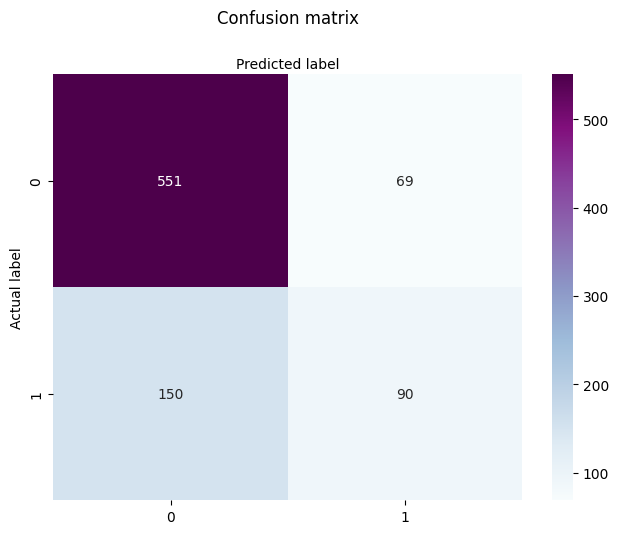

In [312]:
plot_conf_matrix(y_test,y_pred)

#### Task B

In [313]:
train_taskb_augmented_data

,tweet,class_b,class_b_code,class-tuple
0,'''she should ask a few native americans what ...,UNT,1,"(UNT, 1)"
1,'''go home youre drunk maga trump''',TIN,0,"(TIN, 0)"
2,'someone shouldvetaken piece shit volcano',UNT,1,"(UNT, 1)"
3,'''someone shouldvetaken piece shit volcano''',TIN,0,"(TIN, 0)"
4,'oh noes tough shit',UNT,1,"(UNT, 1)"
...,...,...,...,...
6491,'''another democrat scam republicans dont fun...,UNT,1,"(UNT, 1)"
6492,'puss',UNT,1,"(UNT, 1)"
6493,'my pussy',UNT,1,"(UNT, 1)"
6494,'pussy',UNT,1,"(UNT, 1)"


In [314]:
train_taskb_augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6496 entries, 0 to 6495
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         6496 non-null   object
 1   class_b       6496 non-null   object
 2   class_b_code  6496 non-null   int32 
 3   class-tuple   6496 non-null   object
dtypes: int32(1), object(3)
memory usage: 177.8+ KB


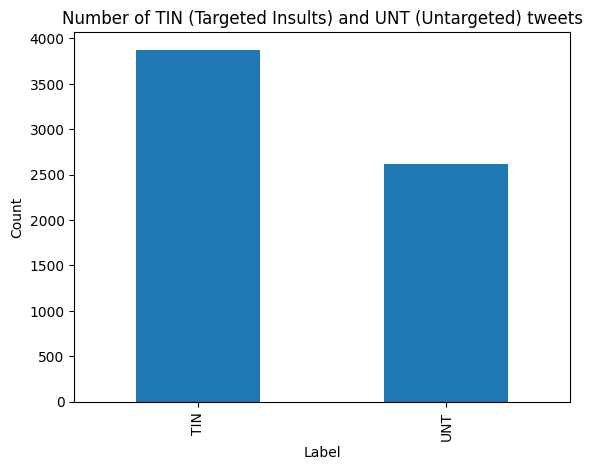

In [315]:
# Assuming 'class_a' is a categorical variable
class_counts = train_taskb_augmented_data['class_b'].value_counts()

class_counts.plot.bar()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of TIN (Targeted Insults) and UNT (Untargeted) tweets')
plt.show()


In [316]:
X_train = train_taskb_augmented_data.tweet
Y_train = train_taskb_augmented_data.class_b

X_test = test_taskb_augmented_data.tweet
Y_test = test_taskb_augmented_data.class_b


le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_train = Y_train.reshape(-1,1)

Y_test = le.fit_transform(Y_test)
Y_test = Y_test.reshape(-1,1)
print(Y_test)

[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


In [317]:
test_taskb_augmented_data


,tweet,class_b,class_b_code
0,'whoisq wherestheserver dumpnike declasfisa de...,TIN,0
1,'nopasaran unity demo to oppose the farright i...,TIN,0
2,'what the fuck did he do this time',TIN,0
3,'get feeling kissing behind humiliate later',TIN,0
4,'nigga ware da hits at',UNT,1
...,...,...,...
343,Howtogetpeopleoutofyourhome ' tell them that y...,UNT,1
344,' citizenry only unfollowed maine for peach as...,UNT,1
345,' about people ... just still unfollowed for m...,UNT,1
346,' just unfollowed me for talking about merlin ...,UNT,1


In [318]:
# Split the Dataset as train and test set

X_train = train_taskb_augmented_data['tweet']
y_train = train_taskb_augmented_data['class_b_code']

X_test = test_taskb_augmented_data['tweet']
y_test = test_taskb_augmented_data['class_b_code']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = y_train.reshape(-1,1)

y_test = le.fit_transform(y_test)
y_test = y_test.reshape(-1,1)
print(y_test)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]


In [319]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model


In [320]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [321]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [322]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [323]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
41/41 [==============================] - 12s 147ms/step - loss: 0.5887 - accuracy: 0.7425 - val_loss: 1.2569 - val_accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 6s 141ms/step - loss: 0.5535 - accuracy: 0.7460 - val_loss: 1.3852 - val_accuracy: 0.0000e+00


In [324]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [325]:
accr = model.evaluate(test_sequences_matrix,y_test)
acc_taskb_lstm=accr
y_pred=model.predict(test_sequences_matrix)
y_pred


11/11 [==============================] - 1s 18ms/step


array([[0.2652379 ],
       [0.21534441],
       [0.30125344],
       [0.40671852],
       [0.45746636],
       [0.180992  ],
       [0.15230009],
       [0.20287459],
       [0.28229776],
       [0.1880527 ],
       [0.18648991],
       [0.45746636],
       [0.15495954],
       [0.34504044],
       [0.21692285],
       [0.21183752],
       [0.37680054],
       [0.17123434],
       [0.21275423],
       [0.16102548],
       [0.22741765],
       [0.19411823],
       [0.1743143 ],
       [0.34515455],
       [0.18969102],
       [0.15608063],
       [0.20286916],
       [0.26747343],
       [0.13940698],
       [0.18158434],
       [0.1680962 ],
       [0.22313774],
       [0.22900593],
       [0.19515598],
       [0.2693759 ],
       [0.26747343],
       [0.26837483],
       [0.2669089 ],
       [0.1877154 ],
       [0.19144848],
       [0.15968683],
       [0.18587916],
       [0.37872255],
       [0.20113432],
       [0.30274028],
       [0.3438909 ],
       [0.17887735],
       [0.227

In [326]:
for i,n in enumerate(y_pred):
    if n<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print(y_pred)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [327]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.645
  Accuracy: 0.612


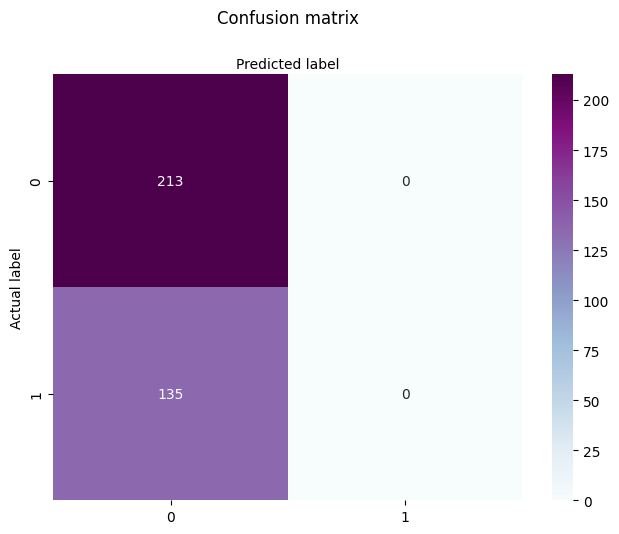

In [328]:
plot_conf_matrix(y_test,y_pred)

#### Task C

In [329]:
test_taskc_augmented_data
    

,tweet,class_c,class_c_code
0,'whoisq wherestheserver dumpnike declasfisa de...,OTH,2
1,'nopasaran unity demo to oppose the farright i...,GRP,0
2,'what the fuck did he do this time',IND,1
3,'get feeling kissing behind humiliate later',OTH,2
4,'stopkavanaugh he is liar like the rest of the...,IND,1
...,...,...,...
243,' as christineblaseyford there was food grindi...,OTH,2
244,' justiceforsoniasfather mr. usman buzdar bach...,OTH,2
245,' these sick ass ppl from school gave me somet...,OTH,2
246,' [UNK] conservatives variants are and dumbert...,OTH,2


In [330]:
# Split the Dataset as train and test set

X_train = train_taskc_augmented_data['tweet']
y_train = train_taskc_augmented_data['class_c_code']

X_test = test_taskc_augmented_data['tweet']
y_test = test_taskc_augmented_data['class_c_code']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = y_train.reshape(-1,1)

y_test = le.fit_transform(y_test)
y_test = y_test.reshape(-1,1)
print(y_test)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[[2]
 [0]
 [1]
 [2]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [2]
 [0]
 [1]
 [0]
 [0]
 [2]
 [2]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [2]
 [2]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [2]
 [0]
 [1]
 [0]
 [2]
 [1]
 [0]
 [0]
 [1]
 [2]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [2]
 [1]
 [0]
 [0]
 [0]
 [2]
 [1]
 [2]
 [1]
 [0]
 [2]
 [0]
 [2]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [2]
 [2]
 [0]
 [1]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [2]
 [1]
 [2]
 [1]
 [1]
 [0]
 [0]
 [2]
 [1]
 [0]
 [1]
 [2]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [2]
 [2]
 [0]
 [2]
 [1]
 [2]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [2]
 [1]
 [0]
 [1]
 [0]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [2]
 [2]
 [1]
 [0]
 [2]
 [1]
 [0]
 [0]
 [0]


In [331]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model


In [332]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [333]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [334]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [335]:
model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
41/41 [==============================] - 8s 145ms/step - loss: 0.3549 - accuracy: 0.4585 - val_loss: -0.4843 - val_accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 7s 162ms/step - loss: 0.2140 - accuracy: 0.4617 - val_loss: -0.8110 - val_accuracy: 0.0046
Epoch 3/10
41/41 [==============================] - 6s 158ms/step - loss: -0.1484 - accuracy: 0.5019 - val_loss: -1.2266 - val_accuracy: 0.1815
Epoch 4/10
41/41 [==============================] - 5s 133ms/step - loss: -2.4174 - accuracy: 0.5402 - val_loss: -8.1986 - val_accuracy: 0.1508
Epoch 5/10
41/41 [==============================] - 5s 134ms/step - loss: -8.0773 - accuracy: 0.5396 - val_loss: -31.4381 - val_accuracy: 0.0789
Epoch 6/10
41/41 [==============================] - 5s 132ms/step - loss: -17.3176 - accuracy: 0.5308 - val_loss: -55.0642 - val_accuracy: 0.0796
Epoch 7/10
41/41 [==============================] - 5s 134ms/step - loss: -27.6131 - accuracy: 0.5237 - val_loss: -61.8400 - val_ac

In [336]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)


In [337]:
accr = model.evaluate(test_sequences_matrix,y_test)
acc_taskc_lstm=accr
y_pred=model.predict(test_sequences_matrix)
y_pred


8/8 [==============================] - 1s 19ms/step


array([[0.526272  ],
       [0.561388  ],
       [1.        ],
       [0.9973832 ],
       [0.52452546],
       [0.98532355],
       [0.5733784 ],
       [0.5989741 ],
       [1.        ],
       [0.5542442 ],
       [1.        ],
       [0.58165735],
       [1.        ],
       [0.59956676],
       [1.        ],
       [0.5835152 ],
       [0.5473006 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.3576052 ],
       [1.        ],
       [0.5297641 ],
       [0.5450822 ],
       [1.        ],
       [0.33579385],
       [0.58336973],
       [0.59869504],
       [1.        ],
       [1.        ],
       [0.42248076],
       [0.5450822 ],
       [0.5934716 ],
       [0.52829146],
       [0.5294038 ],
       [0.4932764 ],
       [1.        ],
       [1.        ],
       [0.5901397 ],
       [0.577195  ],
       [1.        ],
       [0.5383899 ],
       [0.5372137 ],
       [0.5247812 ],
       [0.59771425],
       [0.6012688 ],
       [0.5824045 ],
       [0.520

In [338]:
for i,n in enumerate(y_pred):
    if n<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print(y_pred)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [339]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 3.856
  Accuracy: 0.411


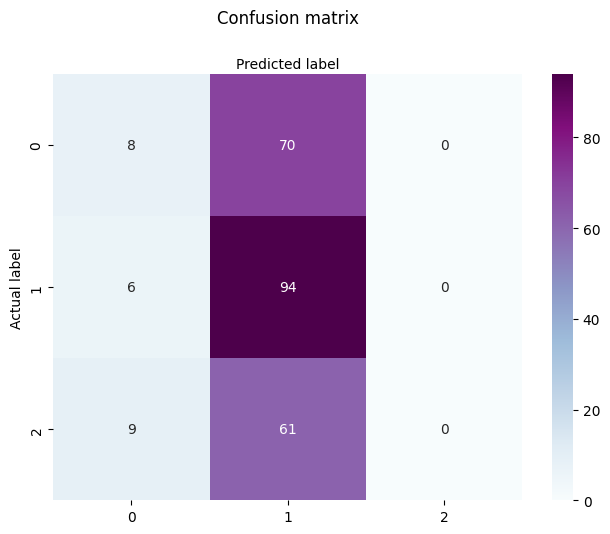

In [340]:
plot_conf_matrix(y_test,y_pred)

In [ ]:
import pandas as pd

# Your variable values (replace these with your actual values)
lstm_task_a = 0.8
lstm_task_b = 0.85
lstm_task_c = 0.75

nb_task_a = 0.75
nb_task_b = 0.82
nb_task_c = 0.78

# Creating a DataFrame
data = {
    'LSTM': [lstm_task_a, lstm_task_b, lstm_task_c],
    'Multinomial NB': [nb_task_a, nb_task_b, nb_task_c]
}

df = pd.DataFrame(data, index=['Task A', 'Task B', 'Task C'])

# Display the DataFrame
print(df)
